In [1]:
import pandas as pd
import numpy as np
import os
import subprocess
import h5py

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

from sklearn.metrics.pairwise import cosine_similarity

data_dir = '../Data'

In [2]:
# get topological order with the pretrained embedding
%run generate_d2gpo_order.py ../Data/3000/new/stocks_emb.w2vec ../Data/3000/new/stocks_emb.order.txt ../Data/3000/new/stocks_emb.order.idx


100%|██████████| 3209/3209 [00:09<00:00, 353.39it/s]


In [13]:
# get the prior distribution for each stocks

# if Gaussian evaluation function

%run generate_d2gpo_distribution.py gaussian 230 0 0 presoftmax 2 ../Data/3000/new/stocks_emb.order.idx ../Data/3000/new/stocks_emb.gaussian_1_0_0.h5

 29%|██▊       | 920/3209 [00:00<00:00, 4575.05it/s]

[0.00031187 0.00031187 0.00031187 ... 0.0003116  0.0003116  0.0003116 ]


100%|██████████| 3209/3209 [00:00<00:00, 4835.29it/s]


In [ ]:
# if linear evaluation function

%run generate_d2gpo_distribution.py linear -0.0003 0 presoftmax 2 ../Data/stocks_emb.order.idx ../Data/stocks_emb.gaussian_1_0_0.h5

In [14]:
# prior distribution data

with h5py.File("../Data/3000/new/stocks_emb.gaussian_1_0_0.h5", 'r') as f:
    dist_data = np.array(f.get('weights'))

dist_data.shape

(3209, 3209)

In [15]:
with open("../Data/3000/new/stocks_emb.order.txt", 'r') as f:
    symbols_txt = f.readlines()
    
with open("../Data/3000/new/stocks_emb.order.idx", 'r') as f:
    symbols_order = f.readlines()

symbols_txt = [x.split(" ") for x in symbols_txt]

In [16]:
temp_ind = [x[0] for x in symbols_txt]
AAPL_ind = [x=='AAPL' for x in temp_ind]
AAPL_ind = [i for i, val in enumerate(AAPL_ind) if val][0]

AAPL_ind

2224

In [17]:
AAPL_prior_dist = pd.concat([pd.Series(temp_ind), pd.Series(dist_data[AAPL_ind,:])], axis=1)
AAPL_prior_dist = AAPL_prior_dist.sort_values([1], ascending=False)
AAPL_prior_dist = AAPL_prior_dist.reset_index()

AAPL_prior_dist

,index,0,1
0,2224,AAPL,0.000312
1,2548,QTEC,0.000312
2,783,SMH,0.000312
3,738,AAXJ,0.000312
4,2525,SOXX,0.000312
...,...,...,...
3204,1258,SRAX,0.000312
3205,1261,NGM,0.000312
3206,1262,NH,0.000312
3207,1263,SSP,0.000312


0.00031159923

In [18]:
MSFT_ind = AAPL_prior_dist.index[AAPL_prior_dist[0] == 'MSFT'].tolist()[0]
FRBA_ind = AAPL_prior_dist.index[AAPL_prior_dist[0] == 'FRBA'].tolist()[0]
BANF_ind = AAPL_prior_dist.index[AAPL_prior_dist[0] == 'BANF'].tolist()[0]

[MSFT_ind, FRBA_ind, BANF_ind]

[48, 2261, 2039]

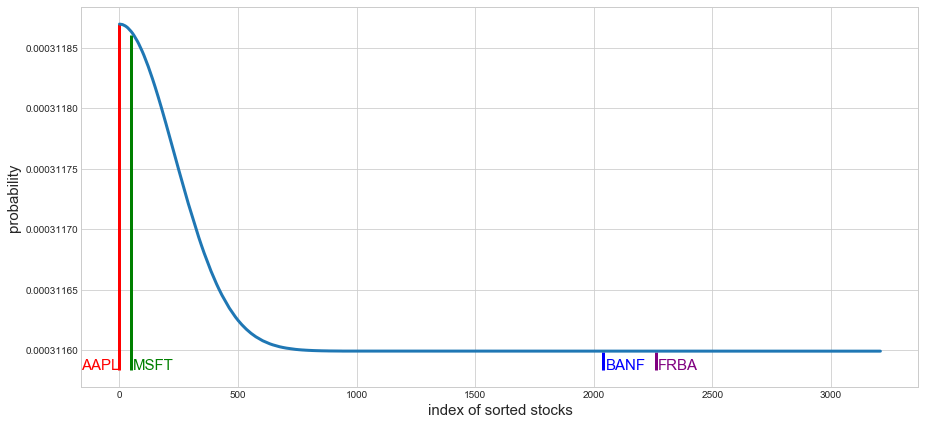

In [50]:
n = 3209
bottom_value = AAPL_prior_dist.loc[n-1].values[2]*0.99995
top_value = AAPL_prior_dist.loc[0].values[2]

f = plt.figure(figsize = (15,7))
plt.plot(list(range(n)), AAPL_prior_dist[1][0:n], linewidth=3)
plt.xlabel('index of sorted stocks', size=15)
plt.ylabel('probability', size=15)

plt.annotate('AAPL', (-162, bottom_value), size=15, color='red')
plt.vlines(0, bottom_value, top_value, color='red', linewidth=3)

plt.annotate('MSFT', (MSFT_ind+10, bottom_value), size=15, color='green')
plt.vlines(MSFT_ind, bottom_value, top_value-0.000000009, color='green', linewidth=3)

plt.annotate('FRBA', (FRBA_ind+10, bottom_value), size=15, color='purple')
plt.vlines(FRBA_ind, bottom_value, bottom_value+0.000000015, color='purple', linewidth=3)

plt.annotate('BANF', (BANF_ind+10, bottom_value), size=15, color='blue')
plt.vlines(BANF_ind, bottom_value, bottom_value+0.000000015, color='blue', linewidth=3)


In [51]:
f.savefig('../Data/3000/new/line_plot.pdf')